# Apply EMC² to an E3SM Hindcast Output

This notebook shows how to apply EMC² to [Energy Exascale Earth System Model (E3SM)](http://e3sm.org) outputs over the DOE Atmospheric Radiation Measurement (ARM) Facility's [North Slope of Alaska (NSA) site](https://www.arm.gov/capabilities/observatories/nsa). 

This notebook looks at generating simulated [High Spectral Resolution Lidar (HSRL)](https://www.arm.gov/capabilities/instruments/hsrl) and [Ka ARM Zenith Radar (KAZR)](https://www.arm.gov/capabilities/instruments/kazr) moments from the model outputs from E3SM for comparison against observations.

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import emc2
import numpy as np
import xarray as xr

## Initializing Instrument Class Objects

EMC² provides instrument classes for both the KAZR and HSRL that are used as inputs for the simulator. These instrument classes are generated by the cell below.

We begin by initalizing an instrument object for the KAZR and one for the HSRL. EMC^2 contains templates for these instruments in `emc2.core.instruments.KAZR` for KAZR and `emc2.core.instruments.HSRL` for the HSRL.

In [2]:
# Set instrument class objects to simulate (a radar and a lidar)
KAZR = emc2.core.instruments.KAZR('nsa')
HSRL = emc2.core.instruments.HSRL()
print("Instrument class generation done!")

Instrument class generation done!


# Select One E3SM NSA Case

Here, we will look at the E3SM hindcast from 2016-08-17 over the ARM North Slope of Alaska (NSA) site. Let's first specify the location of our run.

In [3]:
case = '17'
model_path_CAPT = f'./NSA_hindcast3days_v1_test_0929_201608{case}.cam.h1.2016-08-{case}-00000.nc'

## Generate an `emc2.core.model.E3SM` object 

#### Instead of explicitly using the xarray package to load the data, EMC² can automatically load the data file when generating an `emc2.core.model.E3SM` object. By using EMC² to load a large-scale model's output, we are able to handle 2 potential issues exemplified in the examined E3SM output file:
1. Because E3SM operates a cube-sphere grid, data is not provided in a strict lat-lon grid (two spatial dimensions) but rather on a column basis (one spatial dimension). We need to inform EMC² about that by setting `all_appended_in_lat=True`.

1. The regional output file has appended strings at the end of every field name, the result of post-processing machinery. By setting `appended_str=True`, EMC² can remove these strings by using one of EMC²'s internal methods invoked during initialization.

#### Let's generate an `emc2.core.model.E3SM` object and examine how the loaded data file is shown after initialization as an `xr.Dataset` object.


In [4]:
# Set model class object to use and load model output file.
my_e3sm = emc2.core.model.E3SM(
    model_path_CAPT, all_appended_in_lat=True, appended_str=True)
my_e3sm.ds  # shows the loaded dataset

./NSA_hindcast3days_v1_test_0929_20160817.cam.h1.2016-08-17-00000.nc is a regional output dataset; Stacking the time, lat, and lon dims for processing with EMC^2.


<xarray.Dataset>
Dimensions:              (lev: 72, time_lat_lon: 72, cosp_dbze: 15, nbnd: 2,
                          cosp_ht: 40, cosp_htmisr: 16, cosp_prs: 7,
                          cosp_scol: 10, cosp_sr: 15, cosp_sza: 5, cosp_tau: 7,
                          cosp_tau_modis: 6, ilev: 73, ncol_tmp: 3, time_tmp: 24)
Coordinates: (12/16)
  * cosp_dbze            (cosp_dbze) float64 -47.5 -42.5 -37.5 ... 17.5 22.5
  * cosp_ht              (cosp_ht) float64 240.0 720.0 ... 1.848e+04 1.896e+04
  * cosp_htmisr          (cosp_htmisr) float64 -99.0 0.25 0.75 ... 16.0 58.0
  * cosp_prs             (cosp_prs) float64 900.0 740.0 620.0 ... 245.0 90.0
  * cosp_scol            (cosp_scol) int32 1 2 3 4 5 6 7 8 9 10
  * cosp_sr              (cosp_sr) float64 0.605 2.1 4.0 ... 539.5 1.004e+03
    ...                   ...
  * lev                  (lev) float64 998.5 993.8 986.2 ... 0.1828 0.1238
  * ncol_tmp             (ncol_tmp) int64 0 1 2
  * time_tmp             (time_tmp) datetime64[ns] 2016-08-18 ... 2016-08-18T...
  * time_lat_lon         (time_lat_lon) object MultiIndex
  * ncol                 (time_lat_lon) int64 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2
  * time                 (time_lat_lon) datetime64[ns] 2016-08-18 ... 2016-08...
Dimensions without coordinates: nbnd
Data variables: (12/62)
    ADRAIN               (time_lat_lon, lev) float32 15.4 16.04 ... nan nan
    ADSNOW               (time_lat_lon, lev) float32 nan nan 500.0 ... nan nan
    AREI                 (time_lat_lon, lev) float32 nan nan nan ... nan nan nan
    AREL                 (time_lat_lon, lev) float32 nan nan 7.454 ... nan nan
    CLDICE               (time_lat_lon, lev) float32 0.0 0.0 ... 1.658e-24
    CLDLIQ               (time_lat_lon, lev) float32 6.486e-09 2.568e-05 ... 0.0
    ...                   ...
    sol_tsi              (time_lat_lon) float64 dask.array<chunksize=(72,), meta=np.ndarray>
    time_bnds            (time_lat_lon, nbnd) object dask.array<chunksize=(72, 2), meta=np.ndarray>
    time_written         (time_lat_lon) |S8 dask.array<chunksize=(72,), meta=np.ndarray>
    p_3d                 (time_lat_lon, lev) float64 dask.array<chunksize=(72, 72), meta=np.ndarray>
    zeros_cf             (time_lat_lon, lev) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rho_a                (time_lat_lon, lev) float64 dask.array<chunksize=(72, 72), meta=np.ndarray>
Attributes: (12/19)
    ne:                   30
    np:                   4
    Conventions:          CF-1.0
    source:               CAM
    case:                 AWARE_hindcast3days_v1_test_0929_20160817
    title:                UNSET
    ...                   ...
    history:              Mon Oct  3 00:54:46 2022: ncks -X 202.,205.,70.,73....
    NCO:                  netCDF Operators version 5.0.1 (Homepage = http://n...
    _file_dates:          ['20160818']
    _file_times:          ['000000']
    _datastream:          act_datastream
    _arm_standards_flag:  0

In [5]:
# Include cl ci pl and pi four types hyd
my_e3sm.hyd_types=['cl', 'ci', 'pl','pi']
print(my_e3sm.hyd_types)

['cl', 'ci', 'pl', 'pi']


What time periods do we have available?

In [6]:
my_e3sm.ds.time # has three columns

<xarray.DataArray 'time' (time_lat_lon: 72)>
array(['2016-08-18T00:00:00.000000000', '2016-08-18T01:00:00.000000000',
       '2016-08-18T02:00:00.000000000', '2016-08-18T03:00:00.000000000',
       '2016-08-18T04:00:00.000000000', '2016-08-18T05:00:00.000000000',
       '2016-08-18T06:00:00.000000000', '2016-08-18T07:00:00.000000000',
       '2016-08-18T08:00:00.000000000', '2016-08-18T09:00:00.000000000',
       '2016-08-18T10:00:00.000000000', '2016-08-18T11:00:00.000000000',
       '2016-08-18T12:00:00.000000000', '2016-08-18T13:00:00.000000000',
       '2016-08-18T14:00:00.000000000', '2016-08-18T15:00:00.000000000',
       '2016-08-18T16:00:00.000000000', '2016-08-18T17:00:00.000000000',
       '2016-08-18T18:00:00.000000000', '2016-08-18T19:00:00.000000000',
       '2016-08-18T20:00:00.000000000', '2016-08-18T21:00:00.000000000',
       '2016-08-18T22:00:00.000000000', '2016-08-18T23:00:00.000000000',
       '2016-08-18T00:00:00.000000000', '2016-08-18T01:00:00.000000000',
       '2016-08-18T02:00:00.000000000', '2016-08-18T03:00:00.000000000',
       '2016-08-18T04:00:00.000000000', '2016-08-18T05:00:00.000000000',
       '2016-08-18T06:00:00.000000000', '2016-08-18T07:00:00.000000000',
       '2016-08-18T08:00:00.000000000', '2016-08-18T09:00:00.000000000',
       '2016-08-18T10:00:00.000000000', '2016-08-18T11:00:00.000000000',
       '2016-08-18T12:00:00.000000000', '2016-08-18T13:00:00.000000000',
       '2016-08-18T14:00:00.000000000', '2016-08-18T15:00:00.000000000',
       '2016-08-18T16:00:00.000000000', '2016-08-18T17:00:00.000000000',
       '2016-08-18T18:00:00.000000000', '2016-08-18T19:00:00.000000000',
       '2016-08-18T20:00:00.000000000', '2016-08-18T21:00:00.000000000',
       '2016-08-18T22:00:00.000000000', '2016-08-18T23:00:00.000000000',
       '2016-08-18T00:00:00.000000000', '2016-08-18T01:00:00.000000000',
       '2016-08-18T02:00:00.000000000', '2016-08-18T03:00:00.000000000',
       '2016-08-18T04:00:00.000000000', '2016-08-18T05:00:00.000000000',
       '2016-08-18T06:00:00.000000000', '2016-08-18T07:00:00.000000000',
       '2016-08-18T08:00:00.000000000', '2016-08-18T09:00:00.000000000',
       '2016-08-18T10:00:00.000000000', '2016-08-18T11:00:00.000000000',
       '2016-08-18T12:00:00.000000000', '2016-08-18T13:00:00.000000000',
       '2016-08-18T14:00:00.000000000', '2016-08-18T15:00:00.000000000',
       '2016-08-18T16:00:00.000000000', '2016-08-18T17:00:00.000000000',
       '2016-08-18T18:00:00.000000000', '2016-08-18T19:00:00.000000000',
       '2016-08-18T20:00:00.000000000', '2016-08-18T21:00:00.000000000',
       '2016-08-18T22:00:00.000000000', '2016-08-18T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_lat_lon  (time_lat_lon) object MultiIndex
  * ncol          (time_lat_lon) int64 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
  * time          (time_lat_lon) datetime64[ns] 2016-08-18 ... 2016-08-18T23:...
Attributes:
    long_name:  time
    bounds:     time_bnds

## Running the Subcolumn Generator and Instrument Simulator

#### Now, we use the `emc2.simulator.main.make_simulated_data` method to have EMC² perform a set of (optional) tasks:
1. Generate user-specified number of subcolumns per model grid cell.
1. Run the instrument simualtor.
1. Classify hydrometeor phase using the simulated observables.

#### We first call the `emc2.simulator.main.make_simulated_data` method to calculate the HSRL observables and then call it again to calcualte the KAZR observables (without invoking the subcolumn generator methods again). 
#### Note that because the model output contains the spatial dimension stacked onto the time dimension, we wish to unstack these dimensions once all simualtor operations are done by setting `unstack_dims=True`. 


In [7]:
# Specify number of subcolumns and run simulator (first, for the lidar, then the radar) 
# for both radar and lidar
N_sub = 20
my_e3sm = emc2.simulator.main.make_simulated_data(my_e3sm, HSRL, N_sub, do_classify=False, 
                                                  convert_zeros_to_nan=True,skip_subcol_gen=False)
print("lidar processing done!")

# Radar 
my_e3sm = emc2.simulator.main.make_simulated_data(my_e3sm, KAZR, N_sub,do_classify=False, convert_zeros_to_nan=True,
                                                   unstack_dims=True, finalize_fields=True,use_rad_logic=True) #,,
print("radar processing done!")


## Creating subcolumns...
No convective processing for E3SM
Now performing parallel stratiform hydrometeor allocation in subcolumns
Fully overcast cl & ci in 386 voxels
Done! total processing time = 10.12s
Now performing parallel strat precipitation allocation in subcolumns
Fully overcast pl & pi in 227 voxels
Done! total processing time = 8.82s
Generating lidar moments...
Generating stratiform lidar variables using radiation logic
2-D interpolation of bulk liq lidar backscattering using mu-lambda values
2-D interpolation of bulk liq lidar extinction using mu-lambda values
2-D interpolation of bulk liq lidar backscattering using mu-lambda values
2-D interpolation of bulk liq lidar extinction using mu-lambda values
Done! total processing time = 0.24s
lidar processing done!
## Creating subcolumns...
No convective processing for E3SM
Now performing parallel stratiform hydrometeor allocation in subcolumns
Fully overcast cl & ci in 386 voxels
Done! total processing time = 9.32s
Now performi

## Visualization

#### We can plot EMC² output using matplotlib, xarray's internal methods, or EMC²'s `emc2.plotting.SubcolumnDisplay` object, which is based on the [ACT](https://arm-doe.github.io/ACT/) package. Here, using the `SubcolumnDisplay`'s `plot_subcolumn_timeseries` method, we show the height x time curtain of the first subcolumn (out of the 50 specified) in the grid cell closest to the coordinates of the Utqiagvik specified using the `lat_sel` and `lon_sel` keywords. The hatch patterns invoked by setting `hatched_mask=True`, designate subcolumn bins not detected by the simulated instrument.

cropping lat dim (lat requested = 71.32)


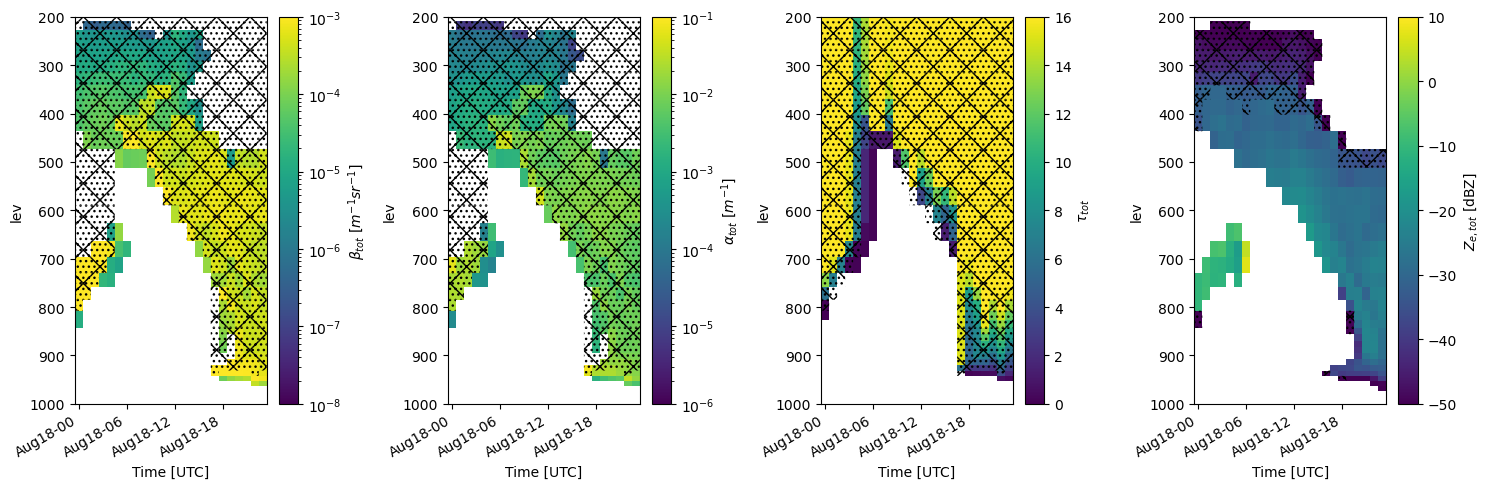

In [8]:
# Set input parameters.
cmap = 'viridis'
field_to_plot = ["sub_col_beta_p_tot", "sub_col_alpha_p_tot", "sub_col_OD_tot", "sub_col_Ze_att_tot"]
vmin_max = [(1e-8,1e-3), (1e-6, 1e-1), (0, 16), (-50., 10.)]
log_plot = [True, True, False, False]
is_radar_field = [False, False, False, True]
y_range = (200., 1e3)  # in hPa
subcol_ind = 0
NSA_coords = {"lat": 71.32, "lon": -156.61}

# Generate a SubcolumnDisplay object for coords closest to the NSA site
model_display = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(1, 4), figsize=(15,5),
                                               lat_sel=NSA_coords["lat"],
                                               lon_sel=NSA_coords["lon"], tight_layout=True)

# set intrument detectability masks for KAZR and HSRL
Mask_array_KAZR_model = model_display.model.ds["detect_mask"].isel(subcolumn=subcol_ind)
Mask_array_HSRL_model = model_display.model.ds["ext_mask"].isel(subcolumn=subcol_ind)

# Plot variables
for ii in range(4):
    if is_radar_field[ii]:
        Mask_array=Mask_array_KAZR_model
    else:
        Mask_array=Mask_array_HSRL_model
    model_display.plot_subcolumn_timeseries(field_to_plot[ii], subcol_ind, log_plot=log_plot[ii], y_range=y_range,
                                            subplot_index=(0, ii),  cmap=cmap, title='',
                                            vmin=vmin_max[ii][0], vmax=vmin_max[ii][1],
                                            Mask_array=Mask_array, hatched_mask=True)

#### For a given subcolumn, we can also plot the output from one of the phase classification algorithms (HSRL-based classification in this case) by using the `plot_subcolumn_timeseries` method followed by calling the `change_plot_to_class_mask`.
#### Another option is to use the phase classification output and the `emc2.simulator.classification.calculate_phase_ratio` method to calcualte the hydrometeor phase partitioning based on all subcolumns, which we can then plot. Here, we also use the `SubcolumnDisplay`'s `fig.savefig` method to save the figure as a PNG file.

# New in 2023 - Lawrence Livermore National Laboratory's added statistics module

Jingjing Tian of Lawrence Livermore National National Laboratory created several new features for EMC^2 to have it support calculating and plotting CFADS, Lidar Scattering Ratio, and cloud fraction in each column. In addition, she improved EMC^2's capability to plot subcolumn timeseries for viewing the time evolution of the cloud microphysics and simulated radar and lidar parameters.

# Input mixing ratios

This code will display the input mixing ratio timeseries that is used to generate the subcolumns. 
This is useful to validate your inputs for the radar simulations as well as to determine the mass of the different water and ice hydrometeor species in E3SM. This first block of code sets the input parameters for the mixing ratio plots, including the fields to plot, the location of NSA, and the plot properties.

In [9]:
# Set input parameters.
cmap = 'Spectral_r'
field_to_plot = ["CLDLIQ", "CLDICE", "RAINQM", "SNOWQM"]
vmin_max = [(0., 0.1),  (0., 0.1), (0., 0.1),(0., 0.1)]
log_plot = [False, False, False, False]
is_radar_field = [False, False, False, False]

y_range = (0, 1)  # in m
subcol_ind = 0
NSA_coords = {"lat": 71.32, "lon": -156.61}
cbar_label = ['CLDLIQ [g/kg]', 'CLDICE [g/kg]', 'RAINQM [g/kg]', 'SNOWQM [g/kg]']
# Figure folder
output_folder_name='Plot'
col_index=2

The bottom two lines of code will use EMC^2's SubcolumnDisplay object to show the mixing ratios in each subcolumn.

cropping lat dim (lat requested = 71.32)


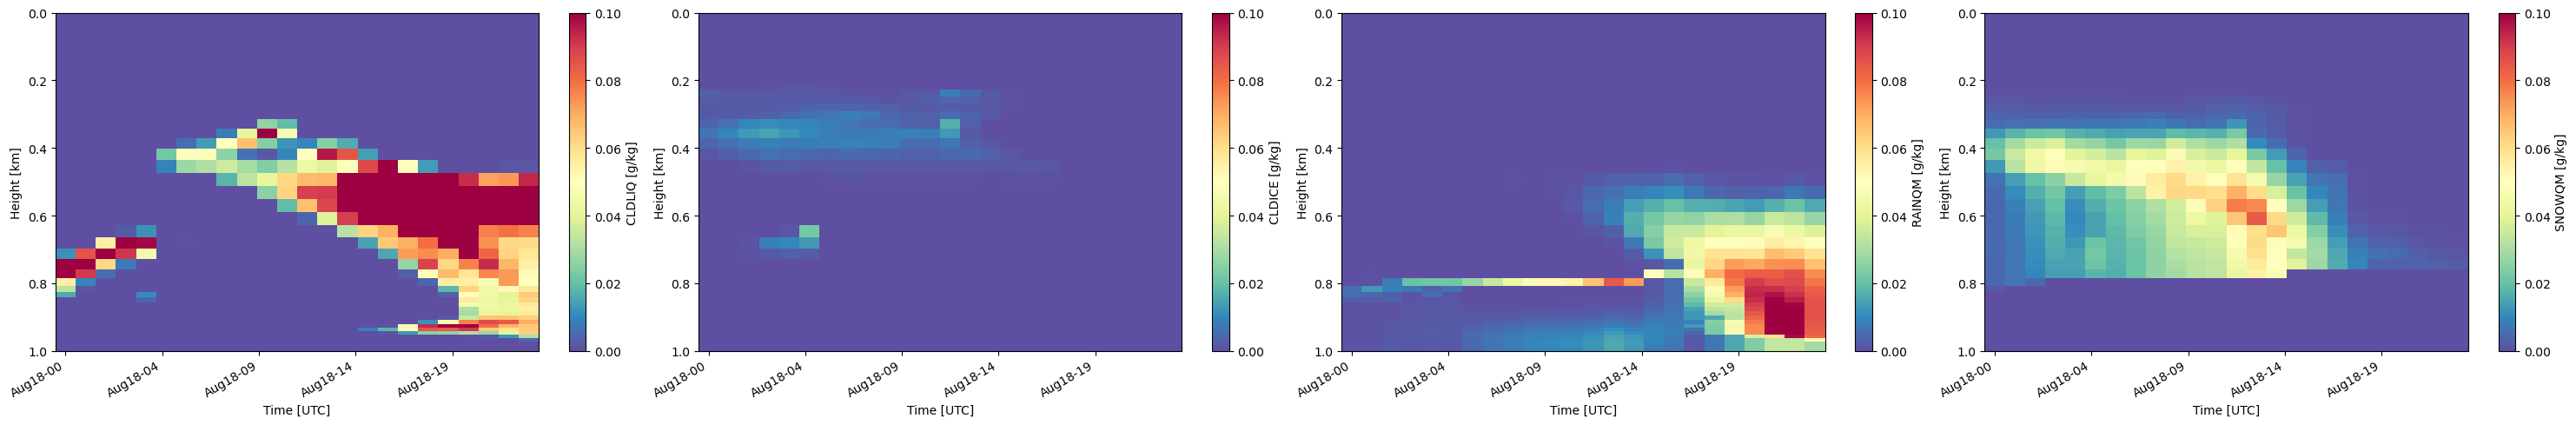

In [10]:
# Generate a SubcolumnDisplay object for coords closest to the NSA site
model_display2 = emc2.plotting.SubcolumnDisplay(my_e3sm, subplot_shape=(1,len(field_to_plot)),
                                                figsize=(15/2.*len(field_to_plot),5),
                                                lat_sel=NSA_coords["lat"],
                                                lon_sel=NSA_coords["lon"],
                                                tight_layout=True)



# Plot variables
for ii, field in enumerate(field_to_plot):
    model_display2.plot_column_input_q_timeseries(field, 
                                                  log_plot=log_plot[ii], y_range=y_range,
                                                  subplot_index=(0, ii),  cmap=cmap, title='',
                                                  vmin=vmin_max[ii][0], vmax=vmin_max[ii][1],
                                                  cbar_label=cbar_label[ii])
    

model_display2.fig.savefig(f'./{output_folder_name}/{case}/Input_Mixing_Ratios_km.png', dpi=150)

# Let's plot all of the subcolumns as a timeseries.

To plot subcolumn mixing ratio from E3SM in a time series, we use:
`emc2.statistics_LLNL.statistical_plots.plot_every_subcolumn_timeseries_mixingratio`

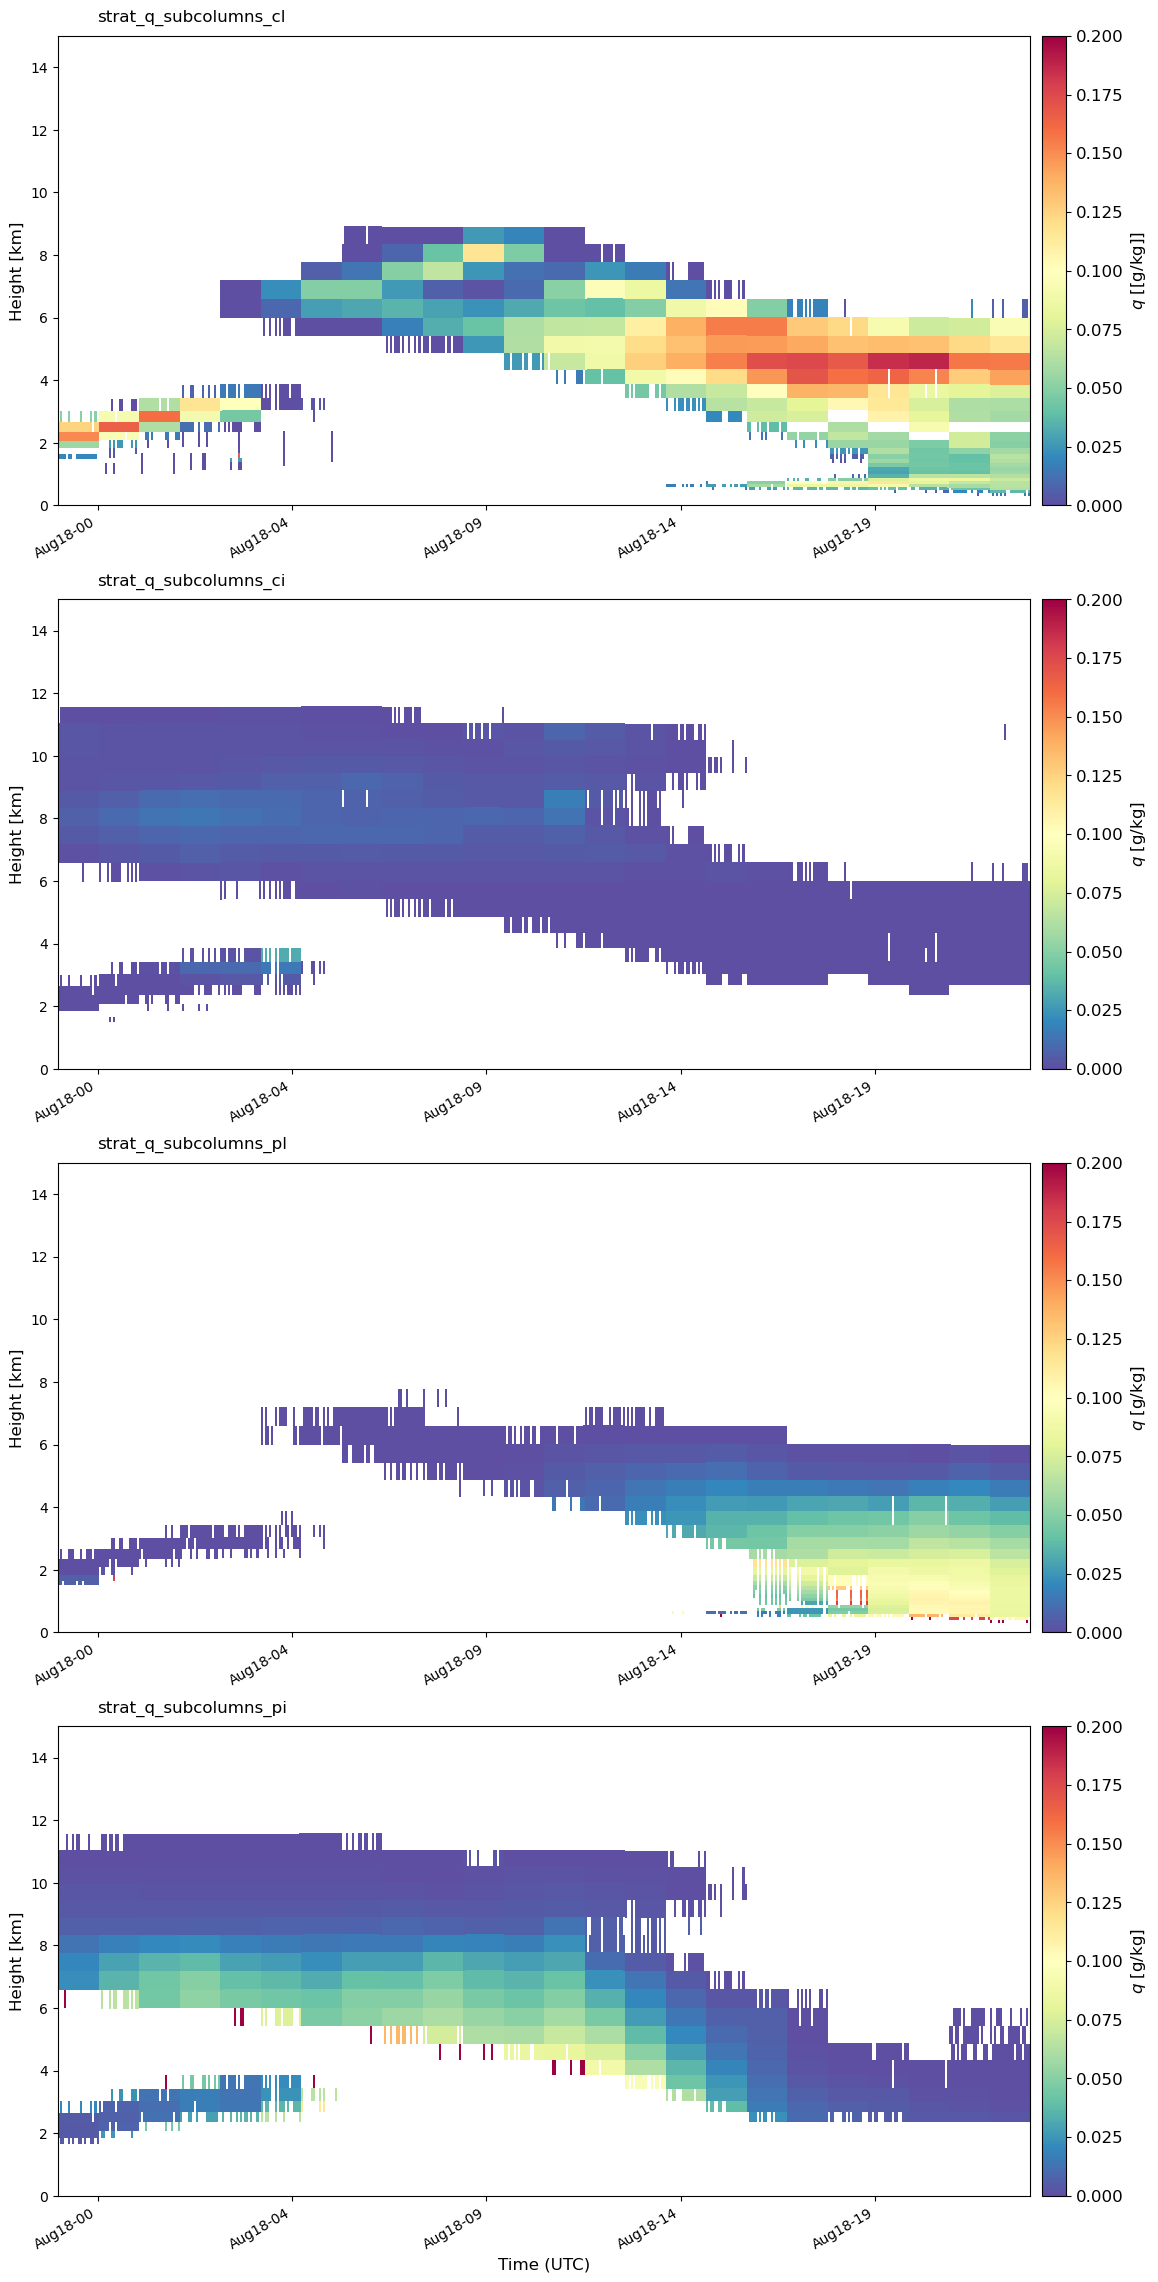

In [11]:
# Plot all subcolumns as a timeseries
emc2.statistics_LLNL.statistical_plots.plot_every_subcolumn_timeseries_mixingratio(
    my_e3sm, col_index, 'save', f'./{output_folder_name}/{case}',
    'radar_radiation_addpl', vmin=0, vmax=0.2)

# CFAD Calculation

Generate the needed radar and lidar variables for calculating the lidar scatter ratio and cloud fraction.
Here, we calculate molecular attenuation `atb_total_4D`, the height of half/full beam attenuation `z_full_km_3D`/`z_half_km_3D`, and the attenuation
corrected reflectivity `Ze_att_total_4D`.


In [12]:
atb_total_4D, atb_mol_4D, z_full_km_3D, z_half_km_3D, Ze_att_total_4D =\
    emc2.statistics_LLNL.statistical_aggregation.get_radar_lidar_signals(
        my_e3sm)

# Calculate lidar scatter ratio (SR)

This code will generate the lidar scatter ratio based off of the E3SM-generated
microphysics values. It calls `emc2.statistics_LLNL.statistical_aggregation.calculate_SR`. 

Here we generate the parameters needed for inputs for the SR calculator,
including the number of subcolumns, time periods, and vertical levels.

In [13]:
# prepare height for vertical regridding in statistical aggregation

subcolum_num = len(my_e3sm.ds.subcolumn)
time_num = len(my_e3sm.ds.time)
col_num = len(my_e3sm.ds.ncol)
lev_num = len(my_e3sm.ds.lev)

Ncolumns = subcolum_num  # subcolumn
Npoints = time_num  # (time and col)
Nlevels = lev_num

Nglevels = 40
zstep = 0.480
levStat_km = np.arange(Nglevels)*zstep+zstep/2.
newgrid_bot = (levStat_km)-0.24
newgrid_top = (levStat_km)+0.24
newgrid_mid = (newgrid_bot+newgrid_top)/2.


In [14]:
SR_4D = emc2.statistics_LLNL.statistical_aggregation.calculate_SR(
    atb_total_4D, atb_mol_4D, subcolum_num, time_num, z_full_km_3D, z_half_km_3D,
    Ncolumns, Npoints, Nlevels, Nglevels, col_num, newgrid_bot, newgrid_top)

# Plot time series of SR

We can plot the timeseries of SR in every subcolumn with `emc2.statistics_LLNL.statistical_plots.plot_every_subcolumn_timeseries_SR`.

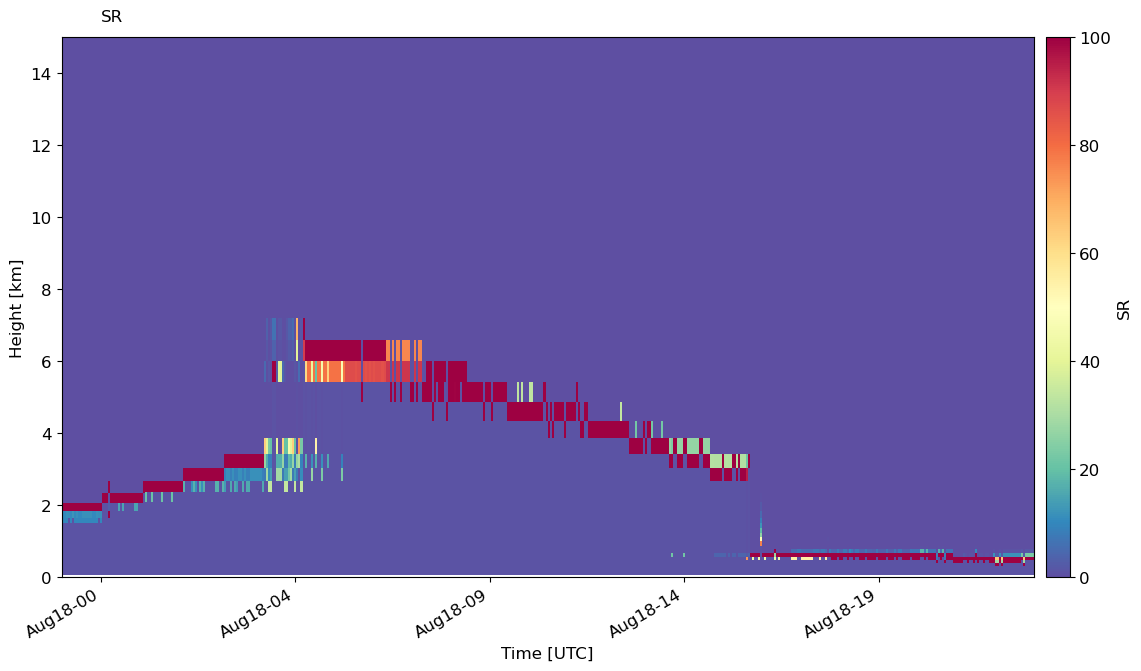

In [15]:
emc2.statistics_LLNL.statistical_plots.plot_every_subcolumn_timeseries_SR(
    my_e3sm, atb_total_4D, atb_mol_4D, col_index, f'./{output_folder_name}/{case}/', 'addpl_rad', 'save', cmap='Spectral_r',
    vmin=0, vmax=100,
    )


# Plot CFAD

Generate CFADs (contour frequency by altitude diagrams) of lidar scatter ratio.
First we specify the histogram bins.

In [16]:
# this is the bins used in COSP

SR_EDGES = np.array([-1., 0.01, 1.2, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 80.0, 999.])
SR_BINS_GR_ground = np.array([-4.950e-01 , 6.050e-01 , 2.100e+00,  4.000e+00,  6.000e+00 , 8.500e+00,1.250e+01 , 1.750e+01,  2.250e+01 , 2.750e+01 , 3.500e+01,  4.500e+01,\
  5.500e+01 , 7.000e+01, 5.395e+02])

Then, calculate the CFADs from the E3SM data.

In [17]:
cfadSR_cal_alltime = emc2.statistics_LLNL.statistical_aggregation.get_cfad_SR(
    SR_EDGES, newgrid_mid, Npoints, Ncolumns, SR_4D, col_index)
print(cfadSR_cal_alltime.shape)


cfadSR_cal_alltime_col = np.empty(
    (Nglevels, len(SR_BINS_GR_ground), len(my_e3sm.ds.ncol.values)))

for i in my_e3sm.ds.ncol.values:
    cfadSR_cal_alltime_col[:, :, i] = emc2.statistics_LLNL.statistical_aggregation.get_cfad_SR(
        SR_EDGES, newgrid_mid, Npoints, Ncolumns, SR_4D, i)

cfadSR_cal_alltime = np.nanmean(cfadSR_cal_alltime_col, axis=2)

(40, 15)


Plot our CFADS! We can see that the distribution is highly 

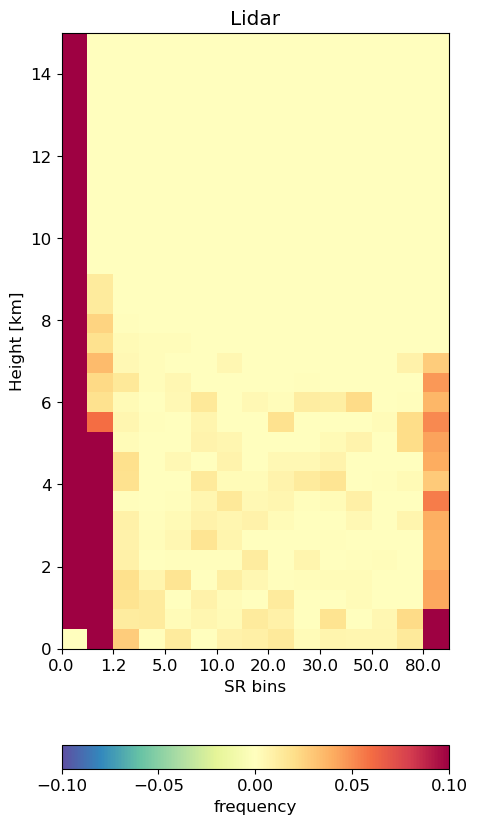

In [18]:
emc2.statistics_LLNL.statistical_plots.plot_lidar_SR_CFAD(
    SR_EDGES, newgrid_mid, cfadSR_cal_alltime, 
    'save', f'./{output_folder_name}/{case}/', 'addpl_rad', cmap='Spectral_r')


## Plotting the radar reflectivity and lidar backscatter side by side!

Finally, another useful plotting function is to plot the simulated radar and lidar moments side by side. For this, we have `emc2.statistics_LLNL.statistical_plots.plot_every_subcolumn_timeseries_radarlidarsignal`, which will plot the radar reflectivity and lidar backscatter side by side.

Here, we can see that liquid at the cloud base is attenuating the lidar signal. However, the reflectivity gives us a better picture of the ice and liquid precipitation above cloud base.

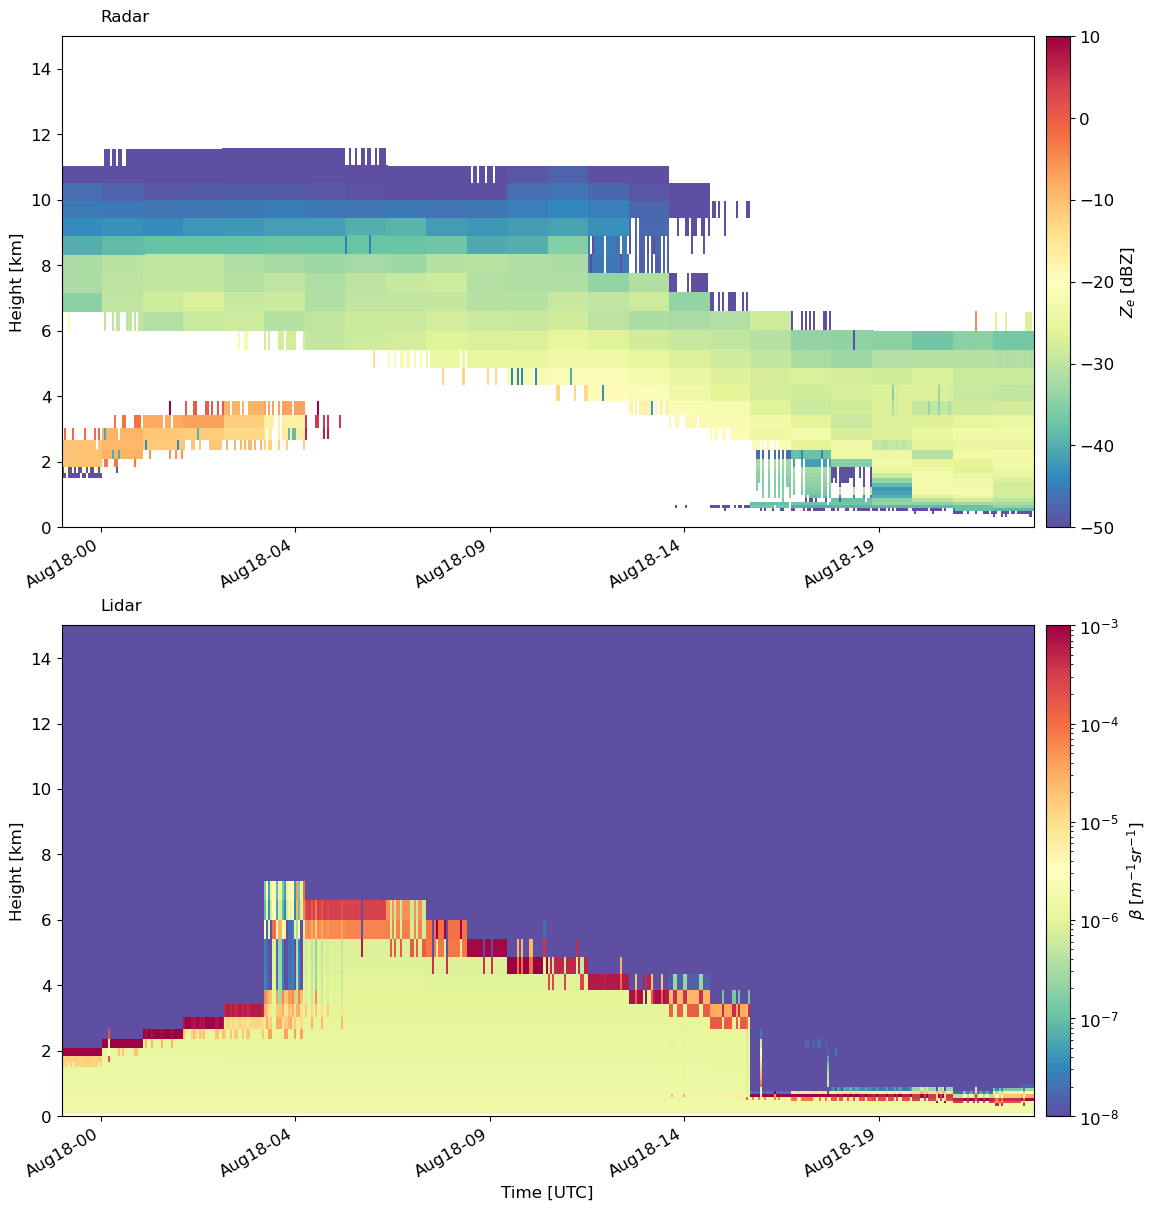

In [19]:
emc2.statistics_LLNL.statistical_plots.plot_every_subcolumn_timeseries_radarlidarsignal(
    my_e3sm, col_index, 'save', f'./{output_folder_name}/{case}/', 'addpl_radiation')



## Resources and References

- [The EMC² manuscript (Silber et al. GMD, 2022)](https://doi.org/10.5194/gmd-15-901-2022)
- [EMC² documentation](https://columncolab.github.io/EMC2/)
- [EMC² source code](https://github.com/columncolab/EMC2)